### Predicting state anxiety of patients from biomarker data (time series of electrical impedance measurements and single point measurements.)
Roshan Mammen Regy
roshanm.regy@tamu.edu


## Load necessary libaries and mount Gdrive

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats

# Scikit learn
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.utils import to_categorical
# Keras 
import keras
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
# Colab
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and preprocess all data sets

In [ ]:
# Load all data sets
# Load average data 
data = pd.read_csv('/content/drive/My Drive/HW5/Homework5/data.csv')
features  = data.columns

# Replace NaN with mean of features 
for i in range(1,len(features)):
  data[features[i]] = data[features[i]].replace(np.nan,np.mean(data[features[i]]))

# Load time series data 
val = data["PID"]
EDA = []
HR = []

for i in val: # Loop over all participants
  d1 = pd.read_excel('/content/drive/My Drive/HW5/Homework5/EDA_PPT_'+str(i)+'.xlsx')
  d2 = pd.read_excel('/content/drive/My Drive/HW5/Homework5/HR_PPT_'+str(i)+'.xlsx')
  #X1 = d1.iloc[:, 0].values.reshape(-1, 1)  
  Y1 = d1.iloc[:, 1].values.reshape(-1, 1)
  #X2 = d2.iloc[:, 0].values.reshape(-1, 1)  
  Y2 = d2.iloc[:, 1].values.reshape(-1, 1)
  EDA.append(Y1)
  HR.append(Y2)

# Time series are of different lengths for different patients
# tf.ragged addresses that issue so RNN can be trained without issues
EDA4RNN = tf.ragged.constant(EDA)
HR4RNN = tf.ragged.constant(HR)

## Data visualization and exploration

In [ ]:
for i in range(1,len(features)-2):
  sns.jointplot(data=data, x="StateAnxiety", y=data[features[i]],kind = "reg")#,hue="species")
  p = stats.pearsonr(data["StateAnxiety"],data[features[i]])
  p = np.round(p[0],4)
  plt.title('p = '+ str(p))
plt.show()

## Feature selection

In [ ]:
###Wrapper method

def wrapper_method(data,n):
  beh_f = ['SCL', 'SCRamp', 'SCRfreq', 'HR', 'BVP', 'TEMP', 'ACC', 'IBI',
       'RMSenergy', 'mfcc[1]', 'mfcc[2]', 'mfcc[3]', 'mfcc[4]', 'mfcc[5]',
       'mfcc[6]', 'mfcc[7]', 'mfcc[8]', 'mfcc[9]', 'mfcc[10]', 'mfcc[11]',
       'mfcc[12]', 'zcr', 'voiceProb', 'F0', 'pause_frequency']

  sfs = SFS(LinearRegression(), k_features=n, forward=True, floating=False,scoring = 'r2', cv = 0)

  sfs.fit(data[beh_f], data["StateAnxiety"])
  selected_f_wrapper = sfs.k_feature_names_
  return selected_f_wrapper

###Filter Method
def filter_method(data,n):
  beh_fil = ['SCL', 'SCRamp', 'SCRfreq', 'HR', 'BVP', 'TEMP', 'ACC', 'IBI',
       'RMSenergy', 'mfcc[1]', 'mfcc[2]', 'mfcc[3]', 'mfcc[4]', 'mfcc[5]',
       'mfcc[6]', 'mfcc[7]', 'mfcc[8]', 'mfcc[9]', 'mfcc[10]', 'mfcc[11]',
       'mfcc[12]', 'zcr', 'voiceProb', 'F0', 'pause_frequency','StateAnxiety']

  X= data[beh_fil]
  importances = X.drop("StateAnxiety", axis=1).apply(lambda x: x.corr(X.StateAnxiety))
  indices = np.argsort(importances)
  selected_f_filer = list(importances[indices].index[0:n])
  return selected_f_filer

def FNN_with_cross_val(X_d,Y_d):

  history = History()

  model = Sequential([
    Dense(units = 32, activation='relu', input_shape=(X_d.shape[1],), name="first_hidden_layer"),
    #Dense(units = 32, activation='relu', name="second_hidden_layer"), Dropout(0.35),
    Dense(units = 16, activation='relu', name="third_hidden_layer"), Dropout(0.35),
    Dense(units = 6, activation='relu', name="fourth_hidden_layer"), Dropout(0.35),
    Dense(units=1)])

  model.compile(optimizer='RMSprop', loss='mse',metrics=['mse'],)
  #loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  X_d = X_d.iloc[:].values
  Y_d = Y_d.iloc[:].values

  err= []
  p = 0
  n=5

  for t in range(0,n):
    Y_test = Y_d[p:len(Y_d)//n+p]
    Y_train = np.array(list(Y_d[0:p])+ list(Y_d[len(Y_d)//n+p:]))
    X_test = X_d[p:len(X_d)//n+p]
    X_train = np.vstack((X_d[0:p],X_d[len(X_d)//n+p:]))
    p = p+len(data)//n
    #print(X_train)
    model.fit(X_train, Y_train, epochs=100, batch_size=10, callbacks=[history], verbose = False)
    #performance = model.evaluate(X_test, Y_test)
    prediction = model.predict(X_test)
    err.append(np.sum(np.abs(np.array(prediction).flatten() - np.array(Y_test)))/len(Y_test))

  return err

err_wr = []
err_fil = []
for j in range(4,25,4):
  selected_f_wrapper  = wrapper_method(data,j)
  selected_f_filer = filter_method(data,j)
  err_wrapper = FNN_with_cross_val(data[list(selected_f_wrapper)],data["StateAnxiety"])
  err_filter = FNN_with_cross_val(data[list(selected_f_filer)],data["StateAnxiety"])
  err_wr.append(np.mean(err_wrapper))
  err_fil.append(np.mean(err_filter))

print(err_wr)
print(err_fil)

KeyboardInterrupt: ignored

RMSprop:[11.345177043568004, 13.008818192915482, 8.92253857750684, 9.804648312655361, 10.011008175936611]
[8.618433172052557, 9.514154607599432, 7.229270061659893, 7.420250285755504, 9.507306185635654]

adem:[11.286710218949752, 11.525269595059482, 9.917475087072713, 10.237640034068715, 11.193400989879262]
[21.55078887939453, 16.996413837779652, 14.161563693473635, 7.883161371404475, 8.186583085493607]

## FNN

In [ ]:
history = History()
n_comp = 3
pca  = PCA(n_components = n_comp)

model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(n_comp,), name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"), Dropout(0.35),
  Dense(units = 16, activation='relu', name="third_hidden_layer"), Dropout(0.35),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"), Dropout(0.35),
  Dense(units=1)])

model.compile(optimizer='adam', loss='mse',metrics=['mse'],)


def FNN_with_cross_val(X_d,Y_d):
  
  X_d = X_d.iloc[:].values
  Y_d = Y_d.iloc[:].values

  err= []
  p = 0
  n=5

  for t in range(0,n):
    Y_test = Y_d[p:len(Y_d)//n+p]
    Y_train = np.array(list(Y_d[0:p])+ list(Y_d[len(Y_d)//n+p:]))
    X_test = X_d[p:len(X_d)//n+p]
    X_train = np.vstack((X_d[0:p],X_d[len(X_d)//n+p:]))
    p = p+len(data)//n
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.fit_transform(X_test)

    model.fit(X_train, Y_train, epochs=50, batch_size=100, callbacks=[history], verbose = False)
    performance = model.evaluate(X_test, Y_test)
    prediction = model.predict(X_test)
    err.append(np.sum(np.abs(np.array(prediction).flatten() - np.array(Y_test)))/len(Y_test))

  return err

err = FNN_with_cross_val(data[beh_fil],data["StateAnxiety"])
print(err)

NameError: ignored

In [ ]:
n_comp = 4
model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(n_comp,), name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"), Dropout(0.35),
  Dense(units = 16, activation='relu', name="third_hidden_layer"), Dropout(0.35),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"), Dropout(0.35),
  Dense(units=1)])

model.compile(optimizer='adam', loss='mse',metrics=['mse'],)
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden_layer (Dense)  (None, 32)                160       
                                                                 
 second_hidden_layer (Dense)  (None, 32)               1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 third_hidden_layer (Dense)  (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 fourth_hidden_layer (Dense)  (None, 6)                102       
                                                                 
 dropout_2 (Dropout)         (None, 6)                 0

## Fit a linear regression model to time series

In [ ]:
val = data["PID"]
linear_features = []
EDA = []
c = 0
EDA11 = np.empty(shape=(1,55),dtype='float')
for i in val:
  d1 = pd.read_excel('/content/drive/My Drive/HW5/Homework5/EDA_PPT_'+str(i)+'.xlsx')
  d2 = pd.read_excel('/content/drive/My Drive/HW5/Homework5/HR_PPT_'+str(i)+'.xlsx')
  #print(d1)
  X1 = d1.iloc[:, 0].values.reshape(-1, 1)  
  Y1 = d1.iloc[:, 1].values.reshape(-1, 1)
  regr = linear_model.LinearRegression()
  regr.fit(X1,Y1)
  X2 = d2.iloc[:, 0].values.reshape(-1, 1)  
  Y2 = d2.iloc[:, 1].values.reshape(-1, 1)
  regr1 = linear_model.LinearRegression()
  regr1.fit(X2,Y2)
  #print(i, regr.coef_[0][0],regr.intercept_)
  linear_features.append([regr.coef_[0][0],regr.intercept_[0], regr1.coef_[0][0],regr1.intercept_[0]])
  #print(regr.intercept_)
  EDA.append(Y1)
  #EDA11[c] = Y1
  c  = c+1

EDA1 = pd.DataFrame(EDA)
df2 = pd.DataFrame(np.array(linear_features), columns = ['EDA_bias','EDA_int','ER_bias','ER_int'])

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


## FNN from time series data

In [ ]:
history = History()

model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(df2.shape[1],), name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"), Dropout(0.35),
  Dense(units = 16, activation='relu', name="third_hidden_layer"), Dropout(0.35),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"), Dropout(0.35),
  Dense(units=1)])

model.compile(optimizer='RMSprop', loss='mse',metrics=['mse'],)
print(model.summary())
def FNN_with_cross_val(X_d,Y_d):

  X_d = X_d.iloc[:].values
  Y_d = Y_d.iloc[:].values

  err= []
  p = 0
  n=5

  for t in range(0,n):
    Y_test = Y_d[p:len(Y_d)//n+p]
    Y_train = np.array(list(Y_d[0:p])+ list(Y_d[len(Y_d)//n+p:]))
    X_test = X_d[p:len(X_d)//n+p]
    X_train = np.vstack((X_d[0:p],X_d[len(X_d)//n+p:]))
    p = p+len(data)//n
    #print(X_train.shape, Y_train.shape)
    #print(X_train)
    model.fit(X_train, Y_train, epochs=1000, batch_size=10, callbacks=[history], verbose = False)
    #performance = model.evaluate(X_test, Y_test)
    prediction = model.predict(X_test)
    err.append(np.sum(np.abs(np.array(prediction).flatten() - np.array(Y_test)))/len(Y_test))

  return err

err_fnn = FNN_with_cross_val(df2,data["StateAnxiety"])
print(err_fnn)

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden_layer (Dense)  (None, 32)                160       
                                                                 
 second_hidden_layer (Dense)  (None, 32)               1056      
                                                                 
 dropout_208 (Dropout)       (None, 32)                0         
                                                                 
 third_hidden_layer (Dense)  (None, 16)                528       
                                                                 
 dropout_209 (Dropout)       (None, 16)                0         
                                                                 
 fourth_hidden_layer (Dense)  (None, 6)                102       
                                                                 
 dropout_210 (Dropout)       (None, 6)               

## LIME FOR FNN FROM TIME SERIES REGRESSION

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
df2['StateAnxiety'] = data['StateAnxiety']
print (df2.columns)

Index(['EDA_bias', 'EDA_int', 'ER_bias', 'ER_int', 'StateAnxiety'], dtype='object')


In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(df2.iloc[:,0:-1]),feature_names = df2.columns[0:-1],class_names=['StateAnxiety'], verbose=True, mode='regression')

In [ ]:
i = 2
exp = explainer.explain_instance(np.array(data.iloc[i,1:-2]),model.predict, num_features=25)

## RNN or LSTM 

In [ ]:
def make_lstm(inputshape):
  model = Sequential()
  model.add(LSTM(units = 32,name="first_hidden_layer", return_sequences = True, input_shape = (inputshape[0],inputshape[1])))
  #model.add(Dropout(0.2))
  model.add(LSTM(units = 32,name="second_hidden_layer", return_sequences = True))
  #model.add(Dropout(0.2))
  model.add(LSTM(units = 16,name="third_hidden_layer", return_sequences = True))
  #model.add(Dropout(0.2))
  model.add(LSTM(units = 6, name="fourth_hidden_layer"))
  #model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='RMSprop', loss='mse', metrics=['mse'])
  return model

In [ ]:
EDAavg = []
for part in EDA:
  start = 0
  end = start+4
  avgpart = []
  for sec in range(int(len(part)/4)):
    avgpart.append([np.mean(part[start:end])])
    start = end
    end = start+4
  EDAavg.append(avgpart)

HRfinal = []
for i in range(len(HR)):
  part=[]
  for j in range(len(HR[i])):
    part.append([HR[i][j][0]])
  HRfinal.append(part)

tot = []
EDARNN = tf.ragged.constant(EDAavg)
HRRNN = tf.ragged.constant(HRfinal)
for part in range(len(EDA)):
  tot.append([EDARNN[part].to_list(),HRRNN[part].to_list()])
  #tot.append([l(EDARNN[part]),list(HRRNN[part])])
totRNN = tf.ragged.constant(tot)

In [ ]:
lstm = make_lstm([HRRNN.shape[0],1])
lstm.fit(HRRNN, data["StateAnxiety"].iloc[:].values , epochs=30)

Epoch 1/30
2/2 [==============================] - 9s 770ms/step - loss: 2239.7910 - mse: 2239.7910
Epoch 2/30
2/2 [==============================] - 2s 771ms/step - loss: 2206.2417 - mse: 2206.2417
Epoch 3/30
2/2 [==============================] - 1s 738ms/step - loss: 2175.2148 - mse: 2175.2148
Epoch 4/30
2/2 [==============================] - 1s 626ms/step - loss: 2146.9170 - mse: 2146.9170
Epoch 5/30
2/2 [==============================] - 2s 747ms/step - loss: 2127.6646 - mse: 2127.6646
Epoch 6/30
2/2 [==============================] - 1s 720ms/step - loss: 2114.9387 - mse: 2114.9387
Epoch 7/30
2/2 [==============================] - 2s 603ms/step - loss: 2104.9011 - mse: 2104.9011
Epoch 8/30
2/2 [==============================] - 1s 588ms/step - loss: 2096.4128 - mse: 2096.4128
Epoch 9/30
2/2 [==============================] - 1s 601ms/step - loss: 2089.1995 - mse: 2089.1995
Epoch 10/30
2/2 [==============================] - 2s 827ms/step - loss: 2082.9414 - mse: 2082.9414
Epoch 11/

In [ ]:
leftindex, foldindex = make_folds(55,5)

Making 5 folds ...
11


In [ ]:
err = np.zeros(5)
for i in range(5):
  lstm = make_lstm([len(leftindex[i]),1])
  foldmat = []
  for ele in leftindex[i]:
    foldmat.append(HRfinal[ele])
  foldmat = tf.ragged.constant(foldmat)

  lstm.fit(foldmat,np.array(data.loc[np.array(leftindex[i]),"StateAnxiety"]),epochs=100)
  testmat = []
  yvals = []
  for ele in foldindex[i]:
    testmat.append(HRfinal[ele])
  testmat = tf.ragged.constant(testmat)
  yvals = []
  
  err[i] = np.mean(np.abs(lstm.predict(testmat)-np.array(data.loc[np.array(foldindex[i]),"StateAnxiety"])))
print (err)
print (np.mean(err))
  



Epoch 1/100
2/2 [==============================] - 10s 561ms/step - loss: 2292.6917 - mse: 2292.6917
Epoch 2/100
2/2 [==============================] - 1s 541ms/step - loss: 2217.8640 - mse: 2217.8640
Epoch 3/100
2/2 [==============================] - 1s 572ms/step - loss: 2183.3179 - mse: 2183.3179
Epoch 4/100
2/2 [==============================] - 1s 571ms/step - loss: 2164.9209 - mse: 2164.9209
Epoch 5/100
2/2 [==============================] - 1s 540ms/step - loss: 2150.4551 - mse: 2150.4551
Epoch 6/100
2/2 [==============================] - 1s 543ms/step - loss: 2137.0303 - mse: 2137.0303
Epoch 7/100
2/2 [==============================] - 1s 556ms/step - loss: 2123.4333 - mse: 2123.4333
Epoch 8/100
2/2 [==============================] - 1s 528ms/step - loss: 2109.0166 - mse: 2109.0166
Epoch 9/100
2/2 [==============================] - 1s 537ms/step - loss: 2094.4612 - mse: 2094.4612
Epoch 10/100
2/2 [==============================] - 1s 560ms/step - loss: 2081.4607 - mse: 2081.460

In [ ]:
!git clone https://github.com/emanuel-metzenthin/Lime-For-Time.git 

Cloning into 'Lime-For-Time'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 190 (delta 32), reused 42 (delta 20), pack-reused 129
Receiving objects: 100% (190/190), 3.09 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
!pip install lime
from lime import explanation
from lime import lime_base
import sys
sys.path.append('/content/Lime-For-Time/')
from lime_timeseries import LimeTimeSeriesExplainer


In [ ]:
print (testmat[0])

<tf.RaggedTensor [[96.2], [96.02], [95.83], [95.65], [95.45], [95.27], [95.15], [95.07], [94.98], [94.87], [94.72], [94.55], [94.48], [94.4], [94.25], [94.18], [94.13], [94.05], [94.0], [94.12], [94.28], [94.4], [94.5], [94.68], [94.87], [95.08], [95.28], [95.42], [95.38], [95.37], [95.3], [95.25], [95.2], [95.18], [95.12], [95.03], [94.97], [94.93], [94.93], [94.92], [94.88], [94.57], [94.27], [93.95], [93.63], [93.28], [92.92], [92.55], [92.23], [91.85], [91.42], [91.17], [90.83], [90.47], [90.12], [90.0], [89.82], [89.62], [89.43], [89.23], [89.02], [88.8], [88.62], [88.4], [88.1], [87.7], [87.3], [86.92], [86.55], [86.23], [85.97], [85.77], [85.52], [85.25], [85.0], [84.68], [84.42], [84.17], [83.9], [83.72], [83.52], [83.35], [83.18], [82.87], [82.52], [82.18], [81.88], [81.6], [81.32], [81.07], [80.93], [80.75], [80.58], [80.37], [80.17], [79.97], [79.78], [79.57], [79.33], [79.1], [78.88], [78.95], [79.03], [79.13], [79.28], [79.37], [79.42], [79.43], [79.32], [79.15], [78.97], 

In [ ]:
explainer = LimeTimeSeriesExplainer(class_names=['StateAnxiety'])
exp2 = explainer.explain_instance(testmat.to_tensor(), lstm.predict, num_features=1, num_samples=5, num_slices=5,replacement_method='noise')

ValueError: ignored

In [ ]:
edaerr = np.zeros(5)
for i in range(5):
  edalstm = make_lstm([len(leftindex[i]),1])
  foldmat = []
  for ele in leftindex[i]:
    foldmat.append(EDA[ele])
  foldmat = tf.ragged.constant(foldmat)

  edalstm.fit(foldmat,np.array(data.loc[np.array(leftindex[i]),"StateAnxiety"]),epochs=5)
  testmat = []
  yvals = []
  for ele in foldindex[i]:
    testmat.append(EDA[ele])
  testmat = tf.ragged.constant(testmat)
  yvals = []
  
  edaerr[i] = np.mean(np.abs(lstm.predict(testmat)-np.array(data.loc[np.array(foldindex[i]),"StateAnxiety"])))
print (edaerr)
print (np.mean(edaerr))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_136/lstm_396/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_136/lstm_396/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 45), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_136/lstm_396/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_136/lstm_395/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_136/lstm_395/RaggedToTensor/bo

2/2 [==============================] - 14s 3s/step - loss: 2251.4873 - mse: 2251.4873
Epoch 2/5
2/2 [==============================] - 6s 2s/step - loss: 2229.4919 - mse: 2229.4919
Epoch 3/5
2/2 [==============================] - 6s 2s/step - loss: 2193.7524 - mse: 2193.7524
Epoch 4/5
2/2 [==============================] - 7s 3s/step - loss: 2149.6555 - mse: 2149.6555
Epoch 5/5
2/2 [==============================] - 7s 3s/step - loss: 2082.0273 - mse: 2082.0273
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_137/lstm_400/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_137/lstm_400/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 45), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_137/lstm_400/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_137/lstm_399/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_137/lstm_399/RaggedToTensor/bo

2/2 [==============================] - 12s 2s/step - loss: 2256.7710 - mse: 2256.7710
Epoch 2/5
2/2 [==============================] - 6s 3s/step - loss: 2237.1990 - mse: 2237.1990
Epoch 3/5
2/2 [==============================] - 6s 2s/step - loss: 2212.0007 - mse: 2212.0007
Epoch 4/5
2/2 [==============================] - 6s 3s/step - loss: 2173.6013 - mse: 2173.6013
Epoch 5/5
2/2 [==============================] - 6s 2s/step - loss: 2121.5615 - mse: 2121.5615
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_138/lstm_404/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_138/lstm_404/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 45), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_138/lstm_404/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_138/lstm_403/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_138/lstm_403/RaggedToTensor/bo

2/2 [==============================] - 14s 3s/step - loss: 2224.4656 - mse: 2224.4656
Epoch 2/5
2/2 [==============================] - 6s 2s/step - loss: 2204.3459 - mse: 2204.3459
Epoch 3/5
2/2 [==============================] - 6s 3s/step - loss: 2182.1841 - mse: 2182.1841
Epoch 4/5
2/2 [==============================] - 7s 3s/step - loss: 2141.8398 - mse: 2141.8398
Epoch 5/5
2/2 [==============================] - 7s 3s/step - loss: 2085.7209 - mse: 2085.7209
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_139/lstm_408/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_139/lstm_408/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 45), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_139/lstm_408/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_139/lstm_407/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_139/lstm_407/RaggedToTensor/bo

2/2 [==============================] - 12s 2s/step - loss: 2256.8467 - mse: 2256.8467
Epoch 2/5
2/2 [==============================] - 7s 3s/step - loss: 2231.6401 - mse: 2231.6401
Epoch 3/5
2/2 [==============================] - 6s 2s/step - loss: 2201.7744 - mse: 2201.7744
Epoch 4/5
2/2 [==============================] - 7s 3s/step - loss: 2160.7190 - mse: 2160.7190
Epoch 5/5
2/2 [==============================] - 6s 2s/step - loss: 2108.5818 - mse: 2108.5818
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_140/lstm_412/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_140/lstm_412/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 45), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_140/lstm_412/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_140/lstm_411/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_140/lstm_411/RaggedToTensor/bo

2/2 [==============================] - 12s 3s/step - loss: 2287.4626 - mse: 2287.4626
Epoch 2/5
2/2 [==============================] - 6s 3s/step - loss: 2270.9875 - mse: 2270.9875
Epoch 3/5
2/2 [==============================] - 6s 2s/step - loss: 2249.9958 - mse: 2249.9958
Epoch 4/5
2/2 [==============================] - 6s 2s/step - loss: 2209.4111 - mse: 2209.4111
Epoch 5/5
2/2 [==============================] - 6s 2s/step - loss: 2154.8999 - mse: 2154.8999
[45.47757251 45.22493201 46.88130811 45.7173403  43.79543758]
45.41931810250587


In [ ]:
lstm2d = make_lstm([55,2])
lstm2d.fit(totRNN, data["StateAnxiety"].iloc[:].values , epochs=20)

## LIME: Explaining relations in datasets and models

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 36.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=69b9c5e9df41138f7c0ba5889c97af52cf44e944ec831416dda34694bf4853c5
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(25,), name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"), Dropout(0.35),
  Dense(units = 16, activation='relu', name="third_hidden_layer"), Dropout(0.35),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"), Dropout(0.35),
  Dense(units=1)])
model.compile(optimizer='adam', loss='mse',metrics=['mse'],)
model.fit(data.iloc[:,1:-2],data.iloc[:,-2], epochs=50, batch_size=100, callbacks=[history], verbose = False)


In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(data.iloc[:,1:-2]),feature_names = data.columns[1:-2],class_names=['StateAnxiety'], verbose=True, mode='regression')

In [ ]:
i = 2
exp = explainer.explain_instance(np.array(data.iloc[i,1:-2]),model.predict, num_features=25)

Intercept 26.603578981253058
Prediction_local [15.89204085]
Right: 14.981907


In [ ]:
exp.show_in_notebook(show_table=True)

## Analysing dataset based on language



In [ ]:
n_comp = 4
model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(n_comp,), name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"), Dropout(0.35),
  Dense(units = 16, activation='relu', name="third_hidden_layer"), Dropout(0.35),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"), Dropout(0.35),
  Dense(units=1)])

model.compile(optimizer='adam', loss='mse',metrics=['mse'],)
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden_layer (Dense)  (None, 32)                160       
                                                                 
 second_hidden_layer (Dense)  (None, 32)               1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 third_hidden_layer (Dense)  (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 fourth_hidden_layer (Dense)  (None, 6)                102       
                                                                 
 dropout_5 (Dropout)         (None, 6)                

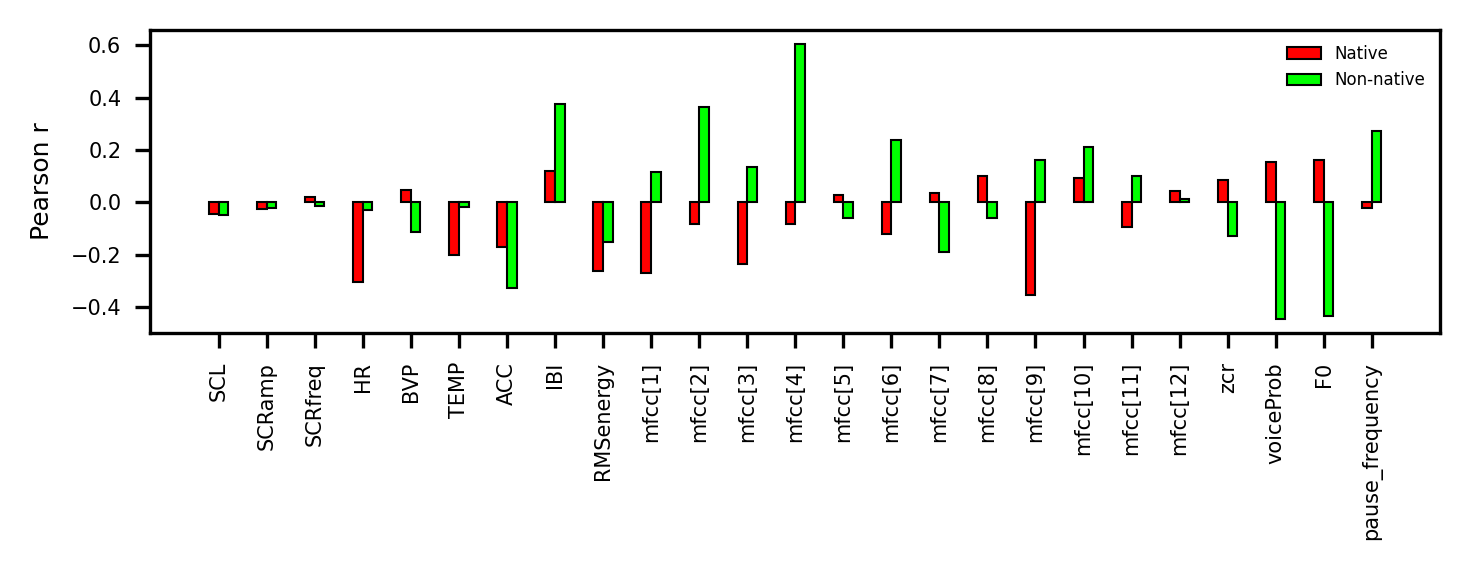

In [ ]:
lang1index = np.where(data['Language']==1)[0]
lang2index = np.where(data['Language']==2)[0]
corr = np.zeros((len(features[1:-2]),2))
for i,fet in enumerate(features[1:-2]):
  corr[i,0] = stats.pearsonr(data.loc[lang1index,'StateAnxiety'],data.loc[lang1index,fet])[0]
  corr[i,1] = stats.pearsonr(data.loc[lang2index,'StateAnxiety'],data.loc[lang2index,fet])[0]

fig,ax = plt.subplots(1,1,dpi=300,figsize=[5,2])
ax.bar(np.arange(0,corr.shape[0]),corr[:,0],color='red',edgecolor='black',linewidth=0.5,width=0.2,label='Native')
ax.bar(np.arange(0.2,corr.shape[0]+0.2),corr[:,1],color='lime',edgecolor='black',linewidth=0.5,width=0.2, label='Non-native')
ax.legend(loc='best',fontsize=4,frameon=False)
ax.tick_params(labelsize=5)
ax.set_xticks(np.arange(0.1,corr.shape[0]+0.1))
ax.set_xticklabels(features[1:-2],rotation=90)
ax.set_ylabel('Pearson r',fontsize=6)
plt.tight_layout()
plt.show()

Features corresponding to non-native speakers seem to have a better correlation with the StateAnxiety label compared to same features for native speakers. 

In [ ]:
# Divide data into folds 
from random import randint
def make_folds(nsample,nfold):
    print ("Making %s folds ..."%nfold)
    foldsize = int(nsample/nfold)
    print (foldsize)
    foldindex = [] # List to save sample indices in each test fold
    leftindex = [] # List to save sample indices in corresponding train fold
    indexlist = list(range(nsample))
    for fold in range(nfold):
        findex = []
        if len(indexlist)>=foldsize:
            for j in range(foldsize):
                pos = randint(0,len(indexlist)-1)
                findex.append(indexlist[pos])
                indexlist.pop(pos)
        elif len(indexlist) < foldsize and len(indexlist) > 0.0:
            findex = indexlist
        foldindex.append(findex)
        lindex = []
        for i in range(nsample):
            if i not in findex:
                lindex.append(i)
        leftindex.append(lindex)
    return (leftindex, foldindex)

In [ ]:
def make_fnn(ncomp):
  model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(ncomp,), \\
        name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"),
  Dense(units = 16, activation='relu', name="third_hidden_layer"),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"),
  Dense(units = 6, activation='relu', name="fifth_hidden_layer"),
  #Dense(units = 6, activation='relu', name="sixth_hidden_layer"),
  Dense(units=1)])
  model.compile(optimizer='adam', loss='mse',metrics=['mse'],)
  return model

Fitting an FNN to native speakers data

In [ ]:
model = make_fnn(len(features[1:-2]))
nfolds = 5
Nleftindex,Nfoldindex = make_folds(len(lang1index)-1, nfolds)
err = np.zeros(nfolds)
for i,fold in enumerate(np.arange(nfolds)):
  model.fit(data.loc[lang1index[Nleftindex[i]],features[1:-2]],data.loc[lang1index[Nleftindex[i]],'StateAnxiety'], epochs=1000, batch_size=10, verbose = False)
  performance = model.evaluate(np.array(data.loc[lang1index[Nfoldindex[i]],features[1:-2]]), np.array(data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
  print (performance)
  print (model.predict(data.loc[lang1index[Nfoldindex[i]],features[1:-2]])[:,0].shape)
  err[i] = np.mean(np.abs(model.predict(data.loc[lang1index[Nfoldindex[i]],features[1:-2]])[:,0]-data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
print (err)
print (np.mean(err))
  


Making 5 folds ...
7
1/1 [==============================] - 0s 126ms/step - loss: 195.5487 - mse: 195.5487
[195.5487060546875, 195.5487060546875]
(7,)
1/1 [==============================] - 0s 19ms/step - loss: 23.8570 - mse: 23.8570
[23.85698127746582, 23.85698127746582]
(7,)
1/1 [==============================] - 0s 20ms/step - loss: 15.7280 - mse: 15.7280
[15.728034973144531, 15.728034973144531]
(7,)
1/1 [==============================] - 0s 19ms/step - loss: 15.2926 - mse: 15.2926
[15.292559623718262, 15.292559623718262]
(7,)
1/1 [==============================] - 0s 19ms/step - loss: 0.4876 - mse: 0.4876
[0.4875620901584625, 0.4875620901584625]
(7,)
[11.34607179  3.87923678  3.6078246   2.80285972  0.45987211]
4.419172997449442


Fitting an FNN to non-native speakers data

In [ ]:
model = make_fnn(len(features[1:-2]))
nfolds = 5
leftindex,foldindex = make_folds(len(lang2index)-1, nfolds)
err = np.zeros(nfolds)
for i,fold in enumerate(np.arange(nfolds)):
  model.fit(data.loc[lang2index[leftindex[i]],features[1:-2]],data.loc[lang2index[leftindex[i]],'StateAnxiety'], epochs=1000, batch_size=10, verbose = False)
  performance = model.evaluate(np.array(data.loc[lang2index[foldindex[i]],features[1:-2]]), np.array(data.loc[lang2index[foldindex[i]],'StateAnxiety']))
  print (performance)
  err[i] = np.mean(np.abs(model.predict(data.loc[lang1index[Nfoldindex[i]],features[1:-2]])[:,0]-data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
print (err)
print (np.mean(err))

Making 5 folds ...
3
1/1 [==============================] - 0s 130ms/step - loss: 488.3120 - mse: 488.3120
[488.3119812011719, 488.3119812011719]
1/1 [==============================] - 0s 19ms/step - loss: 195.8450 - mse: 195.8450
[195.84495544433594, 195.84495544433594]
1/1 [==============================] - 0s 19ms/step - loss: 165.2142 - mse: 165.2142
[165.2141571044922, 165.2141571044922]
1/1 [==============================] - 0s 21ms/step - loss: 12.5237 - mse: 12.5237
[12.52374267578125, 12.52374267578125]
1/1 [==============================] - 0s 20ms/step - loss: 0.1560 - mse: 0.1560
[0.15597327053546906, 0.15597327053546906]
[14.91247722 14.89718109 10.50458472  7.96739279  9.61063058]
11.578453279929187


In [ ]:
selectfet = ['mfcc[4]','voiceProb','F0']
model = make_fnn(len(selectfet))
lerr = np.zeros(nfolds)
for i,fold in enumerate(np.arange(nfolds)):
  model.fit(data.loc[lang2index[leftindex[i]],selectfet],data.loc[lang2index[leftindex[i]],'StateAnxiety'], epochs=1000, batch_size=10, verbose = False)
  performance = model.evaluate(np.array(data.loc[lang2index[foldindex[i]],selectfet]), np.array(data.loc[lang2index[foldindex[i]],'StateAnxiety']))
  print (performance)
  lerr[i] = np.mean(np.abs(model.predict(data.loc[lang1index[Nfoldindex[i]],selectfet])[:,0]-data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
print (lerr)
print (np.mean(lerr))

1/1 [==============================] - 0s 126ms/step - loss: 55.3418 - mse: 55.3418
[55.34183883666992, 55.34183883666992]
1/1 [==============================] - 0s 19ms/step - loss: 163.8668 - mse: 163.8668
[163.86676025390625, 163.86676025390625]
1/1 [==============================] - 0s 19ms/step - loss: 106.5290 - mse: 106.5290
[106.5289535522461, 106.5289535522461]
1/1 [==============================] - 0s 20ms/step - loss: 171.6173 - mse: 171.6173
[171.6173095703125, 171.6173095703125]
1/1 [==============================] - 0s 19ms/step - loss: 0.6677 - mse: 0.6677
[0.6676806807518005, 0.6676806807518005]
[17.39104734 20.15222576 18.4527171  11.36512593  8.51303564]
15.17483035294467


In [ ]:
def wrapper_method(data,n):
  beh_f = data.columns[1:-2]
  sfs = SFS(LinearRegression(), k_features=n, forward=True, floating=False,\\
            scoring = 'r2', cv = 0)
  sfs.fit(data[beh_f], data["StateAnxiety"])
  selected_f_wrapper = sfs.k_feature_names_
  return selected_f_wrapper

In [ ]:
def filter_method(data,n):
  beh_fil = data.columns[1:-1]
  X= data[beh_fil]
  importances = X.drop("StateAnxiety",\\
                       axis=1).apply(lambda x: x.corr(X.StateAnxiety))
  indices = np.argsort(importances)
  selected_f_filer = list(importances[indices].index[0:n])
  return selected_f_filer

SyntaxError: ignored

In [ ]:
selectfet = ['mfcc[4]','voiceProb','F0','mfcc[2]','IBI','ACC']
model = make_fnn(len(selectfet))
for i,fold in enumerate(np.arange(nfolds)):
  model.fit(data.loc[lang2index[leftindex[i]],selectfet],data.loc[lang2index[leftindex[i]],'StateAnxiety'], epochs=1000, batch_size=10, verbose = False)
  performance = model.evaluate((data.loc[lang2index[foldindex[i]],selectfet]), (data.loc[lang2index[foldindex[i]],'StateAnxiety']))
  print (performance)

1/1 [==============================] - 0s 126ms/step - loss: 262.4851 - mse: 262.4851
[262.4851379394531, 262.4851379394531]
1/1 [==============================] - 0s 19ms/step - loss: 154.2231 - mse: 154.2231
[154.22311401367188, 154.22311401367188]
1/1 [==============================] - 0s 18ms/step - loss: 207.0925 - mse: 207.0925
[207.0924530029297, 207.0924530029297]
1/1 [==============================] - 0s 21ms/step - loss: 137.4860 - mse: 137.4860
[137.4860076904297, 137.4860076904297]
1/1 [==============================] - 0s 19ms/step - loss: 75.9726 - mse: 75.9726
[75.97258758544922, 75.97258758544922]


In [ ]:
selectfet  = wrapper_method(data.loc[lang1index,:],4)
print (selectfet)
model = make_fnn(len(selectfet))
wrapper1err = np.zeros(nfolds)
for i,fold in enumerate(np.arange(nfolds)):
  model.fit(data.loc[lang1index[Nleftindex[i]],selectfet],\\
            data.loc[lang1index[Nleftindex[i]],'StateAnxiety'],\\
            epochs=1000, batch_size=10, verbose = False)
  performance = model.evaluate((data.loc[lang1index[Nfoldindex[i]],selectfet]),\\
                               (data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
  print (performance)
  wrapper1err[i] = np.mean(np.abs(model.predict(data.loc[lang1index[Nfoldindex[i]],selectfet])\\
                                  [:,0]-data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
print (wrapper1err)
print (np.mean(wrapper1err))


('SCRfreq', 'HR', 'mfcc[3]', 'mfcc[9]')
1/1 [==============================] - 0s 128ms/step - loss: 43.4986 - mse: 43.4986
[43.49863052368164, 43.49863052368164]
1/1 [==============================] - 0s 19ms/step - loss: 127.9307 - mse: 127.9307
[127.93073272705078, 127.93073272705078]
1/1 [==============================] - 0s 19ms/step - loss: 194.4582 - mse: 194.4582
[194.45822143554688, 194.45822143554688]
1/1 [==============================] - 0s 19ms/step - loss: 144.5792 - mse: 144.5792
[144.57920837402344, 144.57920837402344]
1/1 [==============================] - 0s 20ms/step - loss: 184.4524 - mse: 184.4524
[184.4524383544922, 184.4524383544922]
[ 5.40543474  9.1985885  12.54084124  9.26985877 12.33191872]
9.74932839328019


In [ ]:
selectfet  = wrapper_method(data.loc[lang2index,:],4)
print (selectfet)
model = make_fnn(len(selectfet))
wrapper2err = np.zeros(nfolds)
for i,fold in enumerate(np.arange(nfolds)):
  model.fit(data.loc[lang2index[leftindex[i]],selectfet],\\
            data.loc[lang2index[leftindex[i]],'StateAnxiety'], \\
            epochs=1000, batch_size=10, verbose = False)
  performance = model.evaluate((data.loc[lang2index[foldindex[i]],selectfet]),\\
                               (data.loc[lang2index[foldindex[i]],\\
                                         'StateAnxiety']))
  print (performance)
  wrapper2err[i] = np.mean(np.abs(model.predict\\
                                  (data.loc[lang2index\\[foldindex[i]],\\
                                            selectfet])[:,0]\\
                                  -data.loc[lang2index[foldindex[i]],\\
                                            'StateAnxiety']))
print (wrapper2err)
print (np.mean(wrapper2err))

('mfcc[4]', 'mfcc[5]', 'mfcc[11]', 'F0')
1/1 [==============================] - 0s 129ms/step - loss: 215.9232 - mse: 215.9232
[215.9231719970703, 215.9231719970703]
1/1 [==============================] - 0s 19ms/step - loss: 116.9465 - mse: 116.9465
[116.94654083251953, 116.94654083251953]
1/1 [==============================] - 0s 18ms/step - loss: 119.2548 - mse: 119.2548
[119.25479888916016, 119.25479888916016]
1/1 [==============================] - 0s 19ms/step - loss: 5.7826 - mse: 5.7826
[5.782615661621094, 5.782615661621094]
1/1 [==============================] - 0s 19ms/step - loss: 100.1945 - mse: 100.1945
[100.19445037841797, 100.19445037841797]
[13.76511765  8.3025589  10.73593012  2.07997386  8.53217443]
8.683150990804036


## Filter method for native and non native data sets

In [ ]:
selectfet  = filter_method(data.loc[lang1index,:],4)
print (selectfet)
fmodel = make_fnn(len(selectfet))
fwrapper1err = np.zeros(nfolds)
for i,fold in enumerate(np.arange(nfolds)):
  fmodel.fit(data.loc[lang1index[Nleftindex[i]],selectfet],data.loc[lang1index[Nleftindex[i]],'StateAnxiety'], epochs=1000, batch_size=10, verbose = False)
  performance = fmodel.evaluate((data.loc[lang1index[Nfoldindex[i]],selectfet]), (data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
  print (performance)
  fwrapper1err[i] = np.mean(np.abs(model.predict(data.loc[lang1index[Nfoldindex[i]],selectfet])[:,0]-data.loc[lang1index[Nfoldindex[i]],'StateAnxiety']))
print (fwrapper1err)
print (np.mean(fwrapper1err))

['mfcc[9]', 'HR', 'mfcc[1]', 'RMSenergy']
1/1 [==============================] - 0s 124ms/step - loss: 174.4624 - mse: 174.4624
[174.46243286132812, 174.46243286132812]
1/1 [==============================] - 0s 22ms/step - loss: 83.8146 - mse: 83.8146
[83.81456756591797, 83.81456756591797]
1/1 [==============================] - 0s 18ms/step - loss: 314.2643 - mse: 314.2643
[314.26434326171875, 314.26434326171875]
1/1 [==============================] - 0s 20ms/step - loss: 119.9414 - mse: 119.9414
[119.94144439697266, 119.94144439697266]
1/1 [==============================] - 0s 20ms/step - loss: 110.0767 - mse: 110.0767
[110.07665252685547, 110.07665252685547]
[10.03340966 14.98416818 12.96385847 10.69292559 10.90253775]
11.915379930930163


In [ ]:
selectfet  = filter_method(data.loc[lang2index,:],4)
print (selectfet)
fmodel2 = make_fnn(len(selectfet))
fwrapper2err = np.zeros(nfolds)
for i,fold in enumerate(np.arange(nfolds)):
  fmodel2.fit(data.loc[lang2index[leftindex[i]],selectfet],data.loc[lang2index[leftindex[i]],'StateAnxiety'], epochs=1000, batch_size=10, verbose = False)
  performance = fmodel2.evaluate((data.loc[lang2index[foldindex[i]],selectfet]), (data.loc[lang2index[foldindex[i]],'StateAnxiety']))
  print (performance)
  fwrapper2err[i] = np.mean(np.abs(model.predict(data.loc[lang2index[foldindex[i]],selectfet])[:,0]-data.loc[lang2index[foldindex[i]],'StateAnxiety']))
print (fwrapper2err)
print (np.mean(fwrapper2err))

['voiceProb', 'F0', 'ACC', 'mfcc[7]']
1/1 [==============================] - 0s 123ms/step - loss: 35.6306 - mse: 35.6306
[35.630615234375, 35.630615234375]
1/1 [==============================] - 0s 18ms/step - loss: 14.4638 - mse: 14.4638
[14.46375560760498, 14.46375560760498]
1/1 [==============================] - 0s 20ms/step - loss: 11.2094 - mse: 11.2094
[11.209370613098145, 11.209370613098145]
1/1 [==============================] - 0s 20ms/step - loss: 7.7559 - mse: 7.7559
[7.755865573883057, 7.755865573883057]
1/1 [==============================] - 0s 19ms/step - loss: 2.8975 - mse: 2.8975
[2.8975026607513428, 2.8975026607513428]
[375.06312052 344.89397176 391.33791097 363.36079915 372.15755208]
369.36267089843744


['RMSenergy', 'HR', 'ACC', 'mfcc[9]', 'mfcc[1]']


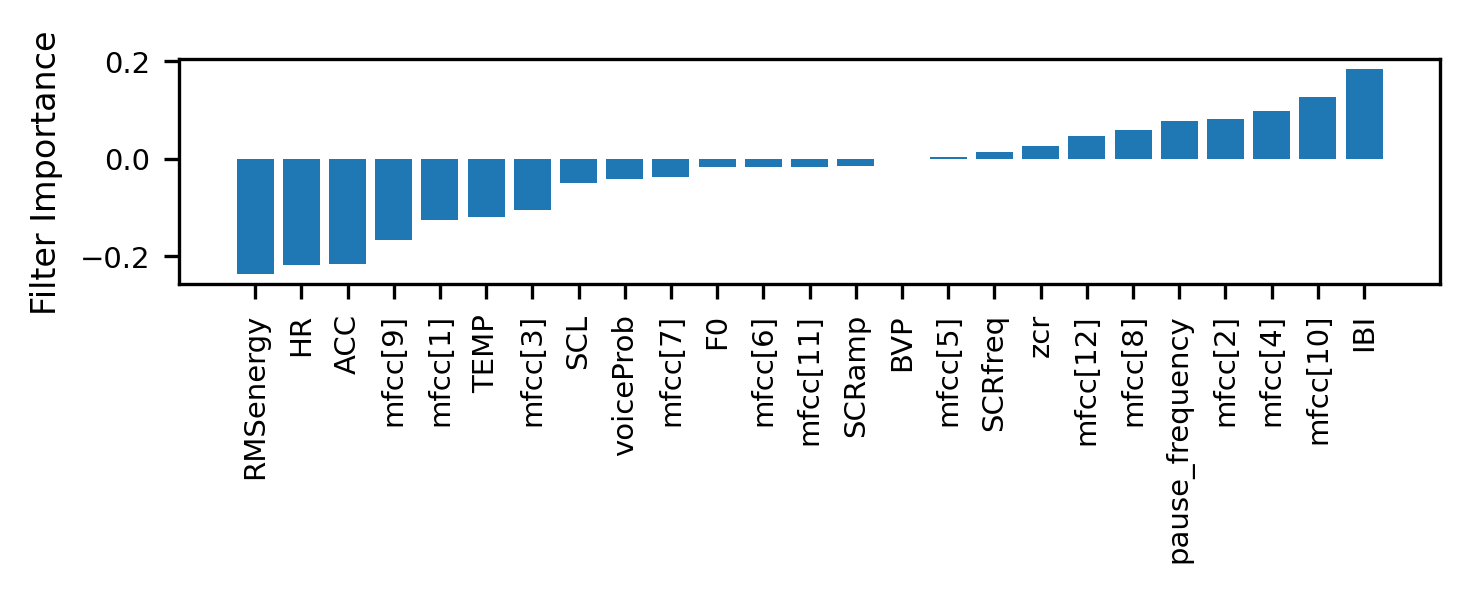

In [ ]:
beh_fil = data.columns[1:-1]
X= data[beh_fil]
importances = X.drop("StateAnxiety", axis=1).apply(lambda x: x.corr(X.StateAnxiety))
indices = np.argsort(importances)
print (list(importances[indices].index[0:5]))
fig,ax = plt.subplots(1,1,dpi=300,figsize=[5,2])
ax.bar(range(len(importances)),importances[indices])
ax.set_xticks(range(len(importances)))
ax.set_xticklabels(list(importances[indices].index[0:]),rotation=90)
ax.set_ylabel('Filter Importance',fontsize=8)
ax.tick_params(labelsize=7)
plt.tight_layout()
plt.show()

## Polynomial regression for time series data

In [ ]:
def poly(a,b,c,d,x):
  return a * np.power(x,3) +b*x*x+ c*x+d

In [ ]:
from scipy.optimize import curve_fit
features = []
EDA = []
c = 0
EDA11 = np.empty(shape=(1,55),dtype='float')
features = np.zeros((55,8))
for cnt,i in enumerate(val):
  d1 = pd.read_excel('/content/drive/My Drive/HW5/Homework5/EDA_PPT_'+str(i)+'.xlsx')
  d2 = pd.read_excel('/content/drive/My Drive/HW5/Homework5/HR_PPT_'+str(i)+'.xlsx')
  #print(d1)
  X1 = d1.iloc[:, 0].values.reshape(-1, 1)  
  Y1 = d1.iloc[:, 1].values.reshape(-1, 1)

  popt, pcov = curve_fit(poly, X1[:,0], Y1[:,0])
  X2 = d2.iloc[:, 0].values
  Y2 = d2.iloc[:, 1].values
  tpopt, tpcov = curve_fit(poly,X2,Y2)
  #print(i, regr.coef_[0][0],regr.intercept_)
 
  features[cnt,:4] =  popt
  features[cnt,4:] = tpopt
  #print(regr.intercept_)
  #EDA11[c] = Y1
  c  = c+1

df2 = pd.DataFrame(np.array(features), columns = ['EDA_a','EDA_b','EDA_c','EDA_d','HR_a','HR_b','HR_c','HR_d'])


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
history = History()

model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(df2.shape[1]-1,), name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"),
  Dense(units = 16, activation='relu', name="third_hidden_layer"),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"),
  #Dense(units = 6, activation='relu', name="fifth_hidden_layer"),
  Dense(units=1)])

model.compile(optimizer='RMSprop', loss='mse',metrics=['mse'],)
print(model.summary())
def FNN_with_cross_val(X_d,Y_d):

  X_d = X_d.iloc[:].values
  Y_d = Y_d.iloc[:].values

  err= []
  p = 0
  n=5

  for t in range(0,n):
    Y_test = Y_d[p:len(Y_d)//n+p]
    Y_train = np.array(list(Y_d[0:p])+ list(Y_d[len(Y_d)//n+p:]))
    X_test = X_d[p:len(X_d)//n+p]
    X_train = np.vstack((X_d[0:p],X_d[len(X_d)//n+p:]))
    p = p+len(data)//n
    #print(X_train.shape, Y_train.shape)
    #print(X_train)
    model.fit(X_train, Y_train, epochs=1000, batch_size=10, callbacks=[history], verbose = False)
    #performance = model.evaluate(X_test, Y_test)
    prediction = model.predict(X_test)
    err.append(np.sum(np.abs(np.array(prediction).flatten() - np.array(Y_test)))/len(Y_test))

  return err

err_fnn = FNN_with_cross_val(df2.iloc[:,0:-1],data["StateAnxiety"])
print(err_fnn)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden_layer (Dense)  (None, 32)                256       
                                                                 
 second_hidden_layer (Dense)  (None, 32)               1056      
                                                                 
 third_hidden_layer (Dense)  (None, 16)                528       
                                                                 
 fourth_hidden_layer (Dense)  (None, 6)                102       
                                                                 
 dense_61 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,949
Trainable params: 1,949
Non-trainable params: 0
_________________________________________________________________
None
[41.204418507489294, 35.674173008311875, 32.19

In [ ]:
df2['StateAnxiety'] = data['StateAnxiety']
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(df2.iloc[:,0:-1]),feature_names = df2.columns[0:-1],class_names=['StateAnxiety'], verbose=True, mode='regression')

In [ ]:
i = 2
exp = explainer.explain_instance(np.array(df2.iloc[i,0:-1]),model.predict, num_features=8)

ValueError: ignored

In [ ]:
exp.show_in_notebook(show_table=True)

## Comparing FNN for native and non native data sets

In [ ]:
# FNN making function 
def make_fnn(comp):
  model = Sequential([
  Dense(units = 32, activation='relu', input_shape=(comp,), name="first_hidden_layer"),
  Dense(units = 32, activation='relu', name="second_hidden_layer"),
  Dense(units = 16, activation='relu', name="third_hidden_layer"),
  Dense(units = 6, activation='relu', name="fourth_hidden_layer"),
  #Dense(units = 6, activation='relu', name="fifth_hidden_layer"),
  Dense(units=1)])

  model.compile(optimizer='RMSprop', loss='mse',metrics=['mse'],)
  return (model)

In [ ]:
# Make an FNN on the whole data set 
model = make_fnn(len(data.columns[1:-2]))
leftindex, foldindex = make_folds(data.shape[0],5)
bestmodel = [] 
min=10000
for fold in range(5):
  model.fit(data.iloc[leftindex[fold],1:-2],data.loc[leftindex[fold],'StateAnxiety'], epochs=1000, batch_size=20,verbose=False)
  perf = model.evaluate(data.iloc[foldindex[fold],1:-2],data.loc[foldindex[fold],'StateAnxiety'])
  if perf[0]<min:
    bestmodel = model
  print (perf)



Making 5 folds ...
11
1/1 [==============================] - 0s 443ms/step - loss: 239.3871 - mse: 239.3871
[239.38711547851562, 239.38711547851562]
1/1 [==============================] - 0s 18ms/step - loss: 37.8048 - mse: 37.8048
[37.804832458496094, 37.804832458496094]
1/1 [==============================] - 0s 18ms/step - loss: 19.8909 - mse: 19.8909
[19.890913009643555, 19.890913009643555]
1/1 [==============================] - 0s 19ms/step - loss: 6.5577 - mse: 6.5577
[6.557738780975342, 6.557738780975342]
1/1 [==============================] - 0s 22ms/step - loss: 4.5625 - mse: 4.5625
[4.562542915344238, 4.562542915344238]


In [ ]:
print (bestmodel.evaluate(data.iloc[:,1:-2],data.loc[:,'StateAnxiety']))
print (bestmodel.evaluate(data.iloc[lang1index,1:-2],data.loc[lang1index,'StateAnxiety']))
print (bestmodel.evaluate(data.iloc[lang2index,1:-2],data.loc[lang2index,'StateAnxiety']))

2/2 [==============================] - 0s 5ms/step - loss: 1.7606 - mse: 1.7606
[1.7606201171875, 1.7606201171875]
2/2 [==============================] - 0s 7ms/step - loss: 1.6012 - mse: 1.6012
[1.6012253761291504, 1.6012253761291504]
1/1 [==============================] - 0s 18ms/step - loss: 2.1169 - mse: 2.1169
[2.116914749145508, 2.116914749145508]


In [ ]:
bestmodel.save('/content/drive/My Drive/HW5/bestFNN_entiredataset')

INFO:tensorflow:Assets written to: /content/drive/My Drive/HW5/bestFNN_entiredataset/assets


In [ ]:
# Data sets split on native(1) and nonnative (2) types 
lang1index = np.where(data['Language']==1)[0]
lang2index = np.where(data['Language']==2)[0]

In [ ]:
# Make an FNN only on lang1 data set
model = make_fnn(len(data.columns[1:-2]))
leftindex, foldindex = make_folds(len(lang1index),5)
bestlang1model = [] 
min=10000
for fold in range(5):
  model.fit(data.iloc[lang1index[leftindex[fold]],1:-2],data.loc[lang1index[leftindex[fold]],'StateAnxiety'], epochs=1000, batch_size=20,verbose=False)
  perf = model.evaluate(data.iloc[lang1index[foldindex[fold]],1:-2],data.loc[lang1index[foldindex[fold]],'StateAnxiety'])
  if perf[0]<min:
    bestlang1model = model
  print (perf)

Making 5 folds ...
7
1/1 [==============================] - 0s 112ms/step - loss: 326.9608 - mse: 326.9608
[326.96075439453125, 326.96075439453125]
1/1 [==============================] - 0s 20ms/step - loss: 71.1279 - mse: 71.1279
[71.1279067993164, 71.1279067993164]
1/1 [==============================] - 0s 21ms/step - loss: 10.7849 - mse: 10.7849
[10.784883499145508, 10.784883499145508]
1/1 [==============================] - 0s 24ms/step - loss: 4.5052 - mse: 4.5052
[4.5051774978637695, 4.5051774978637695]
1/1 [==============================] - 0s 18ms/step - loss: 8.7284 - mse: 8.7284
[8.728353500366211, 8.728353500366211]


In [ ]:
print (bestlang1model.evaluate(data.iloc[:,1:-2],data.loc[:,'StateAnxiety']))
print (bestlang1model.evaluate(data.iloc[lang1index,1:-2],data.loc[lang1index,'StateAnxiety']))
print (bestlang1model.evaluate(data.iloc[lang2index,1:-2],data.loc[lang2index,'StateAnxiety']))

2/2 [==============================] - 0s 6ms/step - loss: 74.5175 - mse: 74.5175
[74.51751708984375, 74.51751708984375]
2/2 [==============================] - 0s 6ms/step - loss: 3.7070 - mse: 3.7070
[3.707026481628418, 3.707026481628418]
1/1 [==============================] - 0s 24ms/step - loss: 232.7998 - mse: 232.7998
[232.7998046875, 232.7998046875]


In [ ]:
# Make an FNN only on lang1 data set
model = make_fnn(len(data.columns[1:-2]))
leftindex, foldindex = make_folds(len(lang2index),5)
bestlang2model = [] 
min=10000
for fold in range(5):
  model.fit(data.iloc[lang2index[leftindex[fold]],1:-2],data.loc[lang2index[leftindex[fold]],'StateAnxiety'], epochs=1000, batch_size=20,verbose=False)
  perf = model.evaluate(data.iloc[lang2index[foldindex[fold]],1:-2],data.loc[lang2index[foldindex[fold]],'StateAnxiety'])
  if perf[0]<min:
    bestlang2model = model
  print (perf)

Making 5 folds ...
3
1/1 [==============================] - 0s 130ms/step - loss: 301.3807 - mse: 301.3807
[301.38067626953125, 301.38067626953125]
1/1 [==============================] - 0s 21ms/step - loss: 6.9296 - mse: 6.9296
[6.929601192474365, 6.929601192474365]
1/1 [==============================] - 0s 18ms/step - loss: 6.0951 - mse: 6.0951
[6.095107555389404, 6.095107555389404]
1/1 [==============================] - 0s 19ms/step - loss: 7.4825 - mse: 7.4825
[7.482544422149658, 7.482544422149658]
1/1 [==============================] - 0s 18ms/step - loss: 0.5581 - mse: 0.5581
[0.5581269264221191, 0.5581269264221191]


In [ ]:
print (bestlang2model.evaluate(data.iloc[:,1:-2],data.loc[:,'StateAnxiety']))
print (bestlang2model.evaluate(data.iloc[lang1index,1:-2],data.loc[lang1index,'StateAnxiety']))
print (bestlang2model.evaluate(data.iloc[lang2index,1:-2],data.loc[lang2index,'StateAnxiety']))

2/2 [==============================] - 0s 6ms/step - loss: 121.6145 - mse: 121.6145
[121.61445617675781, 121.61445617675781]
2/2 [==============================] - 0s 7ms/step - loss: 175.5423 - mse: 175.5423
[175.54232788085938, 175.54232788085938]
1/1 [==============================] - 0s 23ms/step - loss: 1.0698 - mse: 1.0698
[1.0698202848434448, 1.0698202848434448]


## PCA 

25


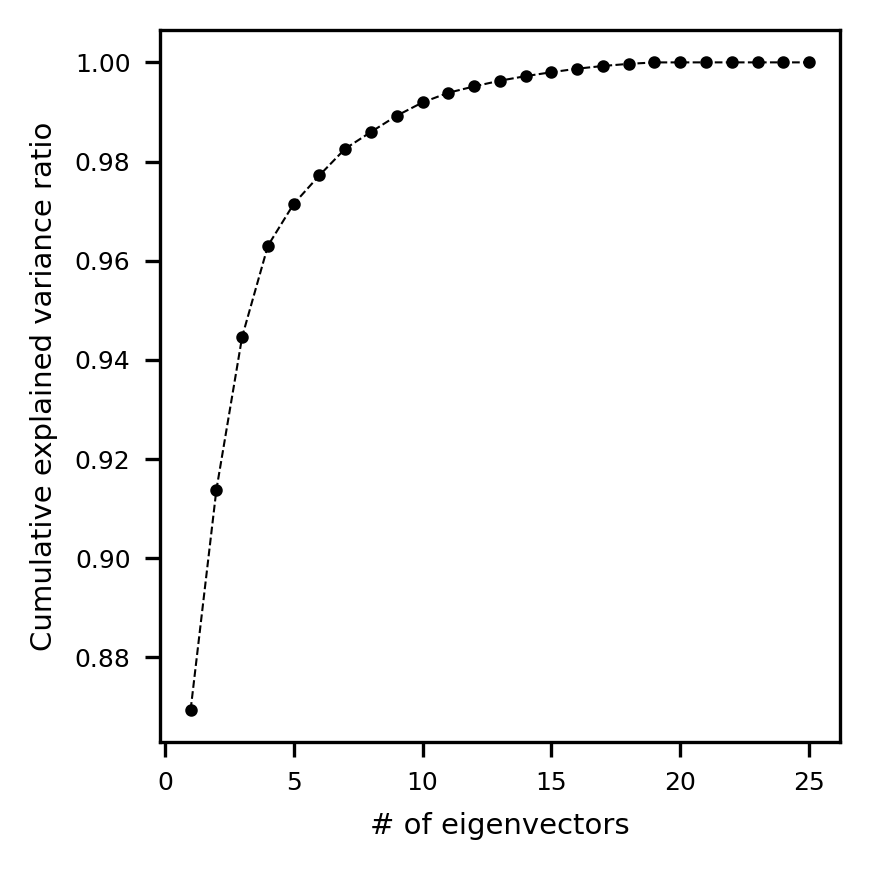

In [ ]:
pca=PCA()
pca.fit(data.iloc[:,1:-2])
print(len(pca.explained_variance_))
fig,ax = plt.subplots(1,1,dpi=300,figsize=[3,3])
sum = []
start = 0
for i in pca.explained_variance_ratio_:
  start +=i
  sum.append(start)
ax.plot(range(1,len(sum)+1),sum,'--o',markersize=2,color='black',lw=0.5)
ax.set_xlabel('# of eigenvectors',fontsize=7)
ax.set_ylabel('Cumulative explained variance ratio',fontsize=7)
ax.tick_params(labelsize=6)
plt.tight_layout()
plt.show()